# 04.5 Token Representation Analysis

Analyze the distribution of token representations under the causal metric.

**Key questions:**
- What is the distribution of causal norms across all 152k tokens?
- Are there distinct populations at different radii?
- Does the distribution reveal training dynamics ("energy landscape")?

**Method:**
1. Load causal metric tensor M
2. Load all token embeddings (γ from lm_head.weight)
3. Compute causal norm for each token: ||v||_M = √(v^T M v)
4. Visualize distribution with histogram
5. Identify and decode extreme tokens

## Configuration

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and paths
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'
METRIC_PATH = Path("../data/vectors/causal_metric_tensor_qwen3_4b.pt")

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

Using device: mps


## Load Metric Tensor and Model

In [6]:
# Load metric tensor
print("Loading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, map_location=device, weights_only=True)
M = metric_data['M']
print(f"M shape: {M.shape}")
print(f"M dtype: {M.dtype}")
print()

# Load model for gamma matrix
print(f"Loading {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

# Extract gamma (unembedding matrix)
gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape
print(f"Gamma shape: {gamma.shape}")
print(f"Vocabulary size: {vocab_size:,} tokens")
print(f"Hidden dimension: {hidden_dim}")
print()

# Load tokenizer for decoding
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

Loading causal metric tensor...
M shape: torch.Size([2560, 2560])
M dtype: torch.float32

Loading Qwen/Qwen3-4B-Instruct-2507...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gamma shape: torch.Size([151936, 2560])
Vocabulary size: 151,936 tokens
Hidden dimension: 2560

Tokenizer loaded.


## Compute Causal Norms for All Tokens

In [7]:
print("Computing causal norms for all tokens...")
print(f"This is {vocab_size:,} quadratic forms: v^T M v")
print()

# Compute all causal norms at once (batched)
# ||v||_M = sqrt(v^T M v) for each row v of gamma
# Shape: gamma is [vocab_size, hidden_dim], M is [hidden_dim, hidden_dim]
# Result: gamma @ M is [vocab_size, hidden_dim]
# Then element-wise multiply with gamma and sum over hidden_dim

causal_norms_squared = (gamma @ M * gamma).sum(dim=1)  # [vocab_size]
causal_norms = torch.sqrt(torch.clamp(causal_norms_squared, min=0))

print(f"Computed {len(causal_norms):,} causal norms.")
print()

# Summary statistics
print("Causal Norm Distribution:")
print(f"  Min:    {causal_norms.min().item():.2f}")
print(f"  Mean:   {causal_norms.mean().item():.2f}")
print(f"  Median: {causal_norms.median().item():.2f}")
print(f"  Max:    {causal_norms.max().item():.2f}")
print(f"  Std:    {causal_norms.std().item():.2f}")
print()

# Coefficient of variation
cv = (causal_norms.std() / causal_norms.mean()).item()
print(f"Coefficient of variation: {cv:.4f} ({cv*100:.1f}%)")

Computing causal norms for all tokens...
This is 151,936 quadratic forms: v^T M v

Computed 151,936 causal norms.

Causal Norm Distribution:
  Min:    21.35
  Mean:   54.13
  Median: 55.26
  Max:    85.29
  Std:    7.90

Coefficient of variation: 0.1460 (14.6%)


## Visualize Distribution

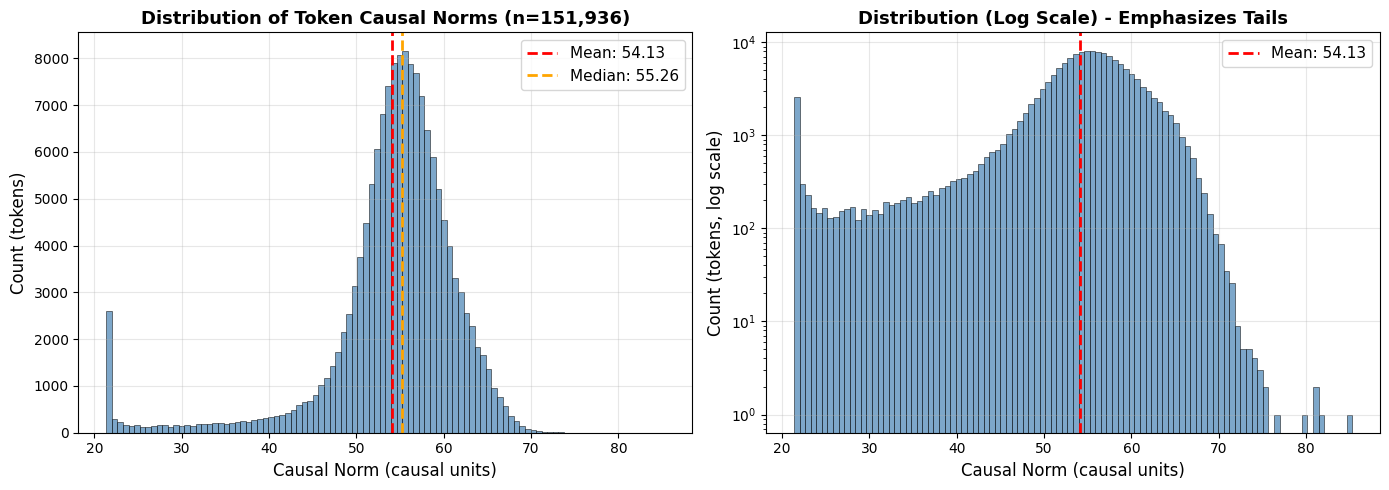


Histogram shows the full distribution across all 152k tokens.
Left: Linear scale (shows main peak)
Right: Log scale (emphasizes tails and secondary populations)


In [8]:
# Convert to numpy for plotting
norms_np = causal_norms.cpu().numpy()

# Create histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with fine bins
ax1.hist(norms_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.axvline(norms_np.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {norms_np.mean():.2f}')
ax1.axvline(np.median(norms_np), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(norms_np):.2f}')
ax1.set_xlabel('Causal Norm (causal units)', fontsize=12)
ax1.set_ylabel('Count (tokens)', fontsize=12)
ax1.set_title(f'Distribution of Token Causal Norms (n={vocab_size:,})', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Log-scale histogram to see tails
ax2.hist(norms_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_yscale('log')
ax2.axvline(norms_np.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {norms_np.mean():.2f}')
ax2.set_xlabel('Causal Norm (causal units)', fontsize=12)
ax2.set_ylabel('Count (tokens, log scale)', fontsize=12)
ax2.set_title('Distribution (Log Scale) - Emphasizes Tails', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nHistogram shows the full distribution across all 152k tokens.")
print("Left: Linear scale (shows main peak)")
print("Right: Log scale (emphasizes tails and secondary populations)")

## Identify Extreme Tokens

In [9]:
# Find tokens with smallest and largest causal norms
n_extremes = 20

# Sort by causal norm
sorted_indices = torch.argsort(causal_norms)

# Smallest norms
smallest_indices = sorted_indices[:n_extremes]
smallest_norms = causal_norms[smallest_indices]

# Largest norms  
largest_indices = sorted_indices[-n_extremes:].flip(0)  # Reverse to show largest first
largest_norms = causal_norms[largest_indices]

print(f"\n{'='*60}")
print(f"TOKENS WITH SMALLEST CAUSAL NORMS (n={n_extremes})")
print(f"{'='*60}\n")

for i, (idx, norm) in enumerate(zip(smallest_indices, smallest_norms), 1):
    token_id = idx.item()
    token_str = tokenizer.decode([token_id])
    print(f"{i:2d}. Token {token_id:6d} | Norm: {norm.item():6.2f} | '{token_str}'")

print(f"\n{'='*60}")
print(f"TOKENS WITH LARGEST CAUSAL NORMS (n={n_extremes})")
print(f"{'='*60}\n")

for i, (idx, norm) in enumerate(zip(largest_indices, largest_norms), 1):
    token_id = idx.item()
    token_str = tokenizer.decode([token_id])
    print(f"{i:2d}. Token {token_id:6d} | Norm: {norm.item():6.2f} | '{token_str}'")


TOKENS WITH SMALLEST CAUSAL NORMS (n=20)

 1. Token 150904 | Norm:  21.35 | '듷'
 2. Token 103909 | Norm:  21.43 | '�'
 3. Token 149801 | Norm:  21.45 | '햑'
 4. Token 121774 | Norm:  21.45 | '䦃'
 5. Token 149961 | Norm:  21.45 | '�'
 6. Token 150112 | Norm:  21.46 | '옼'
 7. Token 151000 | Norm:  21.46 | '엃'
 8. Token 149802 | Norm:  21.49 | '햤'
 9. Token 150905 | Norm:  21.52 | '딮'
10. Token 147930 | Norm:  21.52 | '🖏'
11. Token 147895 | Norm:  21.53 | '꿴'
12. Token 150900 | Norm:  21.54 | '됸'
13. Token 151007 | Norm:  21.54 | '옾'
14. Token 151017 | Norm:  21.54 | '잳'
15. Token 148631 | Norm:  21.55 | '괞'
16. Token 123642 | Norm:  21.56 | '𬶠'
17. Token 150796 | Norm:  21.56 | '㫪'
18. Token 149112 | Norm:  21.59 | '텦'
19. Token 151078 | Norm:  21.59 | '튽'
20. Token 122976 | Norm:  21.59 | '�'

TOKENS WITH LARGEST CAUSAL NORMS (n=20)

 1. Token 151643 | Norm:  85.29 | '<|endoftext|>'
 2. Token    198 | Norm:  82.06 | '
'
 3. Token  72363 | Norm:  81.18 | ' ​​'
 4. Token   4102 | Norm:  8

## Percentile Analysis

In [10]:
# Compute percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(norms_np, percentiles)

print("\nPercentile Analysis:")
print(f"{'Percentile':<12} {'Causal Norm':>12}")
print("-" * 24)
for p, v in zip(percentiles, percentile_values):
    print(f"{p:>3d}th{' '*7} {v:>12.2f}")

# IQR (Interquartile Range)
q1, q3 = percentile_values[3], percentile_values[5]  # 25th and 75th
iqr = q3 - q1
print(f"\nInterquartile Range (IQR): {iqr:.2f}")
print(f"50% of tokens lie within [{q1:.2f}, {q3:.2f}]")


Percentile Analysis:
Percentile    Causal Norm
------------------------
  1th               21.79
  5th               39.06
 10th               47.05
 25th               51.88
 50th               55.26
 75th               58.53
 90th               61.79
 95th               63.73
 99th               66.78

Interquartile Range (IQR): 6.65
50% of tokens lie within [51.88, 58.53]


## Higher-Order Statistics

In [11]:
from scipy import stats

# Skewness and kurtosis
skewness = stats.skew(norms_np)
kurtosis = stats.kurtosis(norms_np)  # Excess kurtosis (normal = 0)

print("\nHigher-Order Statistics:")
print(f"  Skewness: {skewness:.4f}")
if skewness < -0.5:
    print("    → Left-skewed (heavy tail toward small values)")
elif skewness > 0.5:
    print("    → Right-skewed (heavy tail toward large values)")
else:
    print("    → Approximately symmetric")

print(f"\n  Kurtosis: {kurtosis:.4f}")
if kurtosis > 1:
    print("    → Heavy-tailed (more extreme values than normal distribution)")
elif kurtosis < -1:
    print("    → Light-tailed (fewer extreme values than normal)")
else:
    print("    → Similar tail behavior to normal distribution")

print("\nInterpretation:")
print("  These statistics quantify departures from a simple Gaussian.")
print("  Large |skewness| or |kurtosis| suggest multiple populations")
print("  or non-random structure in the distribution.")


Higher-Order Statistics:
  Skewness: -1.9678
    → Left-skewed (heavy tail toward small values)

  Kurtosis: 5.5690
    → Heavy-tailed (more extreme values than normal distribution)

Interpretation:
  These statistics quantify departures from a simple Gaussian.
  Large |skewness| or |kurtosis| suggest multiple populations
  or non-random structure in the distribution.


## Summary

This notebook computed the causal norm ||v||_M = √(v^T M v) for all 152,936 tokens in the vocabulary.

**Key findings:**
- Distribution shape (see histogram)
- Extreme tokens (smallest/largest norms)
- Statistical characterization (percentiles, skewness, kurtosis)

**Interpretation:**
The distribution reveals how tokens are arranged radially in causal space. Distinct populations at different radii may correspond to:
- Undertrained/rare tokens (small norms)
- Normal vocabulary (central peak)
- Structural/special tokens (large norms)

This "energy landscape" reflects training dynamics - where gradient descent pushed tokens during optimization.